<a href="https://colab.research.google.com/github/RaoSharjeelKhan/Machine-Learning/blob/main/Brain_Tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras_tuner import RandomSearch
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
!pip install kaggle
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 96% 83.0M/86.8M [00:02<00:00, 42.9MB/s]
100% 86.8M/86.8M [00:02<00:00, 31.2MB/s]


In [ ]:
from zipfile import ZipFile
DT="/content/brain-tumor-classification-mri.zip"
with ZipFile(DT, 'r') as zip:
  zip.extractall()

In [ ]:
train_dir='/content/Training'
test_dir='/content/Testing'

In [ ]:
train_df=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',    
    
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)
val_df=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',    
    
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.13,
    subset="validation",
)
test_df=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 373 files for validation.
Found 394 files belonging to 4 classes.


In [ ]:
print(len(train_df),len(val_df),len(test_df))

72 12 13


In [ ]:
class_names = train_df.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
train_df.as_numpy_iterator()

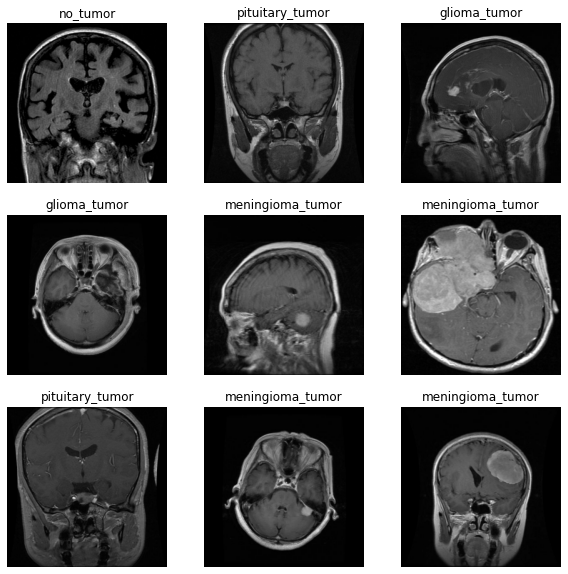

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history=model.fit(
  train_df,
  validation_data=val_df,
  epochs=10
)

Epoch 1/10
72/72 [==============================] - 6s 74ms/step - loss: 1.0245 - accuracy: 0.5710 - val_loss: 0.7156 - val_accuracy: 0.7051
Epoch 2/10
72/72 [==============================] - 7s 86ms/step - loss: 0.4941 - accuracy: 0.7970 - val_loss: 0.6048 - val_accuracy: 0.7534
Epoch 3/10
72/72 [==============================] - 6s 73ms/step - loss: 0.2873 - accuracy: 0.8907 - val_loss: 0.4929 - val_accuracy: 0.8472
Epoch 4/10
72/72 [==============================] - 6s 73ms/step - loss: 0.1508 - accuracy: 0.9447 - val_loss: 0.4638 - val_accuracy: 0.8606
Epoch 5/10
72/72 [==============================] - 6s 73ms/step - loss: 0.0637 - accuracy: 0.9813 - val_loss: 0.6127 - val_accuracy: 0.8445
Epoch 6/10
72/72 [==============================] - 6s 72ms/step - loss: 0.0480 - accuracy: 0.9839 - val_loss: 0.7410 - val_accuracy: 0.8686
Epoch 7/10
72/72 [==============================] - 6s 73ms/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.7888 - val_accuracy: 0.8740
Epoch 8/10
72

## Using Hyper-parameter tuning to find the best hyperparameter for our model

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential([
        
        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(
            hp.Int('conv_1_filter', min_value=8, max_value=64, step=8), 
            hp.Choice('conv_1_kernel', values=[3,5]), 
            activation=hp.Choice('conv_1_activation', values=['relu'])
        ),
        tf.keras.layers.MaxPooling2D(),


        tf.keras.layers.Conv2D(
            hp.Int('conv_2_filter', min_value=16, max_value=128, step=16), 
            hp.Choice('conv_2_kernel', values=[3,5]), 
            activation=hp.Choice('conv_2_activation', values=['relu'])
        ),
        tf.keras.layers.MaxPooling2D(),


        tf.keras.layers.Conv2D(
            hp.Int('conv_3_filter', min_value=32, max_value=256, step=32), 
            hp.Choice('conv_3_kernel', values=[3,5]), 
            activation=hp.Choice('conv_3_activation', values=['relu'])
        ),
        tf.keras.layers.MaxPooling2D(),


        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(
            hp.Int('dense_1_units', min_value=64, max_value=512, step=64), 
            activation=hp.Choice('dense_1_activation', values=['relu'])
        ),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir1',
    project_name='my_project1')


tuner.search(train_df, epochs=15, validation_data=(val_df))

#best_model = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 19s]
val_accuracy: 0.8793565630912781

Best val_accuracy So Far: 0.9034852385520935
Total elapsed time: 00h 25m 52s


In [ ]:
num_classes = 4

model_1 = tf.keras.Sequential([
  
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(96, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(96, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(448, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model_1.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
history_1=model_1.fit(
  train_df,
  validation_data=val_df,
  epochs=10
)

Epoch 1/10
72/72 [==============================] - 9s 119ms/step - loss: 0.9932 - accuracy: 0.6002 - val_loss: 0.7127 - val_accuracy: 0.7078
Epoch 2/10
72/72 [==============================] - 9s 119ms/step - loss: 0.5574 - accuracy: 0.7827 - val_loss: 0.5557 - val_accuracy: 0.7909
Epoch 3/10
72/72 [==============================] - 9s 119ms/step - loss: 0.3365 - accuracy: 0.8706 - val_loss: 0.4617 - val_accuracy: 0.8070
Epoch 4/10
72/72 [==============================] - 9s 120ms/step - loss: 0.2073 - accuracy: 0.9207 - val_loss: 0.3948 - val_accuracy: 0.8552
Epoch 5/10
72/72 [==============================] - 9s 118ms/step - loss: 0.1458 - accuracy: 0.9456 - val_loss: 0.3228 - val_accuracy: 0.8794
Epoch 6/10
72/72 [==============================] - 9s 118ms/step - loss: 0.0733 - accuracy: 0.9752 - val_loss: 0.3739 - val_accuracy: 0.8686
Epoch 7/10
72/72 [==============================] - 9s 118ms/step - loss: 0.0680 - accuracy: 0.9760 - val_loss: 0.5005 - val_accuracy: 0.8633
Epoch 

##Accuracy And Loss Graph before hyper parameter tuning

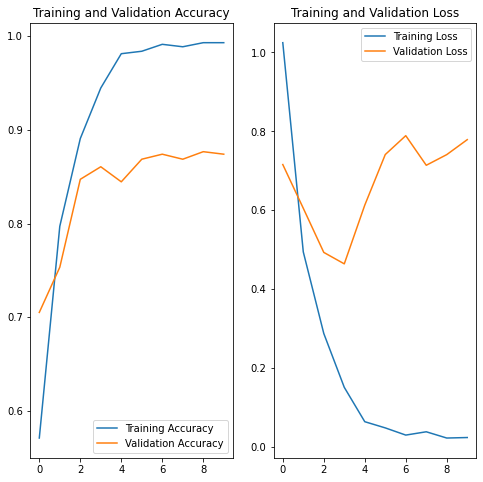

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Accuracy And Loss Graph After hyper parameter tuning

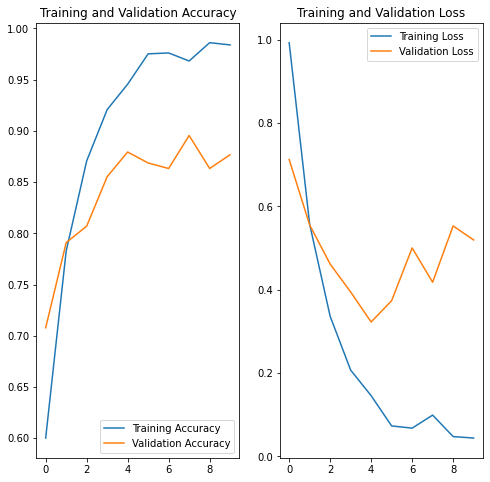

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()